# Discrete frame-level variational autoenoders

Ryan Eloff, ryan.peter.eloff@gmail.com, February 2019.

Based on code from the following paper:
- H. Kamper, "Truly unsupervised acoustic word embeddings using weak top-down constraints in encoder-decoder models," *arXiv preprint arXiv:1811.00403*, 2018. [[arXiv](https://arxiv.org/abs/1811.00403)][[code](https://github.com/kamperh/recipe_bucktsong_awe)]

### Preamble

Re-load all modules before executing Python cells, and use the matplotlib 'inline' backend:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import os
import sys

In [4]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [5]:
sys.path.append(os.path.join("..", "src"))
sys.path.append(os.path.join("..", "embeddings"))

In [6]:
from constants import TF_FLOAT_DTYPE
from constants import TF_INT_DTYPE
from constants import NP_INT_DTYPE
from tf_base.models import ae
from tf_base.models import rnn
from tf_base import training
from tf_base import vis
from utils import batching

In [7]:
output_dir = "tmp"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Load data

In [8]:
def read_npz(npz, quiet=True):
    keys = []
    x = []
    x_lengths = []
    speakers = []
    num_data = 0
    for utterance_key in sorted(npz.keys()):
        # process next utterance
        data = npz[utterance_key]
        length = data.shape[0]
        speaker = utterance_key.split('_')[0][:3]
        # store utterance data
        x.append(data)
        x_lengths.append(length)
        speakers.append(speaker)
        num_data += 1
    if not quiet:
        print('No. of utterances in npz:', num_data)
    return {"keys": keys,
            "x": x,
            "x_lengths": x_lengths,
            "speakers": speakers}

In [9]:
language = "english"
input_feats = "mfcc"  # one of "mfcc" or "fbank"
recon_feats = "mfcc"  # one of "mfcc" or "fbank"

feats_dir = os.path.join("..", "features")
mfcc_dir = os.path.join(feats_dir, "mfcc", language)
fbank_dir = os.path.join(feats_dir, "fbank", language)

# Load npz data (sorted keys of mfcc and fbank train/test are the same):
mfcc_train_npz = np.load(os.path.join(mfcc_dir, "train.dd.npz"))
mfcc_test_npz = np.load(os.path.join(mfcc_dir, "test.dd.npz"))
fbank_train_npz = np.load(os.path.join(fbank_dir, "train.npz"))
fbank_test_npz = np.load(os.path.join(fbank_dir, "test.npz"))

# Read input data
if input_feats is "mfcc":
    input_train = read_npz(mfcc_train_npz, quiet=False)
    input_test = read_npz(mfcc_test_npz, quiet=False)
    dim_input_feats = 13  # remove MFCC delta & delta-delta
else:  # fbank
    input_train = read_npz(fbank_train_npz, quiet=False)
    input_test = read_npz(fbank_test_npz, quiet=False)
    dim_recon_feats = input_train["x"][0].shape[-1]  # full feature dimensionality
    
# Read reconstruction data
if recon_feats is "mfcc":
    recon_train = read_npz(mfcc_train_npz, quiet=False)
    recon_test = read_npz(mfcc_test_npz, quiet=False)
    dim_recon_feats = 13  # remove MFCC delta & delta-delta
else:  # fbank
    recon_train = read_npz(fbank_train_npz, quiet=False)
    recon_test = read_npz(fbank_test_npz, quiet=False)
    dim_recon_feats = recon_train["x"][0].shape[-1]  # full feature dimensionality

No. of utterances in npz: 44136
No. of utterances in npz: 13994
No. of utterances in npz: 44136
No. of utterances in npz: 13994


In [10]:
print("E.g. item shape:", input_train["x"][0].shape)

E.g. item shape: (147, 39)


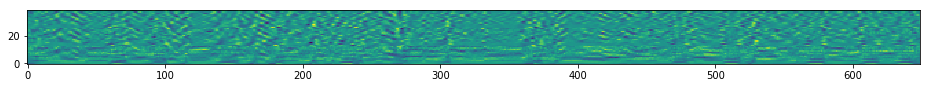

In [11]:
plt.figure(figsize=(16, 6))
plt.imshow(input_train["x"][14473].T, origin="bottom")

In [12]:
# Convert speakers to integers
all_speakers = set(input_train["speakers"]) | set(input_train["speakers"])  # union speaker sets
speaker_to_id = {}  # speaker->id lookup
id_to_speaker = {}  # id->speaker lookup
for index, speaker in enumerate(sorted(list(all_speakers))):
    speaker_to_id[speaker] = index
    id_to_speaker[index] = speaker
    
# Get train speaker ids
train_speaker_id = []
for speaker in input_train["speakers"]:
    train_speaker_id.append(speaker_to_id[speaker])
train_speaker_id = np.array(train_speaker_id, dtype=NP_INT_DTYPE)

# Get test speaker ids
test_speaker_id = []
for speaker in input_train["speakers"]:
    test_speaker_id.append(speaker_to_id[speaker])
test_speaker_id = np.array(test_speaker_id, dtype=NP_INT_DTYPE)

speaker_gender_dict = {
    # ...?
}

Largest x length: 1400 frames
2 std deviations (95%): 395 frames
Outliers above max_length=600: 0.387 %


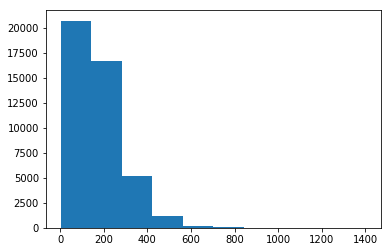

In [13]:
max_length = 600
num_outliers = 0
two_std = np.mean(input_train["x_lengths"]) + 2*np.std(input_train["x_lengths"])
for x_length in input_train["x_lengths"]:
    num_outliers += 1 if x_length > max_length else 0

# Display train_x_length stats
plt.hist(input_train["x_lengths"])
print("Largest x length: {:d} frames".format(np.max(input_train["x_lengths"])))
print("2 std deviations (95%): {:d} frames".format(int(round(two_std))))
print("Outliers above max_length={:d}: {:.3f} %".format(max_length,
                                                        num_outliers/len(input_train["x_lengths"])*100))

In [14]:
# Truncate and limit dimensionality
def truncate_segments(max_length, x, x_lengths, dim_frame_feats=13):    
    for i, seq in enumerate(x):
        x[i] = x[i][:max_length, :dim_frame_feats]
        x_lengths[i] = min(x_lengths[i], max_length)

truncate_segments(max_length, input_train["x"], input_train["x_lengths"], dim_input_feats)
truncate_segments(max_length, input_test["x"], input_test["x_lengths"], dim_input_feats)
truncate_segments(max_length, recon_train["x"], recon_train["x_lengths"], dim_recon_feats)
truncate_segments(max_length, recon_test["x"], recon_test["x_lengths"], dim_recon_feats)

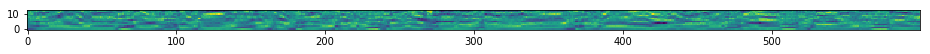

In [15]:
plt.figure(figsize=(16, 6))
plt.imshow(input_train["x"][14473].T, origin="bottom")

### Many-to-many sequence-to-sequence model with frame-level latent transformation (autoencoder)

In [16]:
# TODO(rpeloff): should rename this to `def build_the_thing_with_to_many_words(...)`
def build_multi_layer_many_to_many_with_latent(
        x_input, x_lengths, encoder_hidden_units, decoder_hidden_units, latent_transform, latent_kwargs,
        rnn_cell="lstm", rnn_cell_kwargs=None, keep_prob=1., decoder_conditioning=None, dim_output_feats=None):
    """Build a multi-layer many-to-many sequence-to-sequence model with per-frame latent layers.
    
    Note: The decoders output is processed by a linear transformation such that the final
    output dimensionality matches that of the input `x_input`. 
    
    TODO(rpeloff): function doc
    
    `decoder_conditioning`: 
        Optionally condition the decoder on the concatenation of the latent representation and this tensor.
    """
    max_length = tf.math.reduce_max(x_lengths)  # compute maximum along the lengths tensor
    x_tensor = tf.convert_to_tensor(x_input)
    dim_features = x_tensor.get_shape().as_list()[-1]  # get input features dimensionality
    if dim_output_feats is None:
        dim_output_feats = dim_features

    # Multi-layer RNN encoder
    # -----------------------
    encoder_output, encoder_states = rnn.build_multi_layer_rnn(
        x_tensor, x_lengths, encoder_hidden_units, rnn_cell, rnn_cell_kwargs, keep_prob, scope="rnn_encoder")
    
    # Latent transformation
    # ---------------------
    encoder_output_flattened = tf.reshape(encoder_output, [-1, encoder_hidden_units[-1]])
    latent_output = latent_transform(encoder_output_flattened, **latent_kwargs)
    recon_output = latent_output["y"]  # latent reconstruction output
    
    dim_recon_output = recon_output.get_shape().as_list()[-1]  # get latent layer feature dimensionality
    recon_output = tf.reshape(recon_output, [-1, max_length, dim_recon_output])  # reshaped (n_data, frames, feats)
    
    # Additional decoder conditioning
    # -------------------------------
    if decoder_conditioning is not None:
        dim_conditioning_tensor = decoder_conditioning.get_shape().as_list()[-1]
        tiled_conditioning = tf.reshape(  # tile conditioning tensor to max_length
            tf.tile(decoder_conditioning, [1, max_length]), [-1, max_length, dim_conditioning_tensor])
        # TODO(rpeloff): should dim_conditioning_tensor == dim_recon_output?
        decoder_input = tf.concat([recon_output, tiled_conditioning], axis=-1)
    else:
        decoder_input = recon_output
        
    # Multi-layer RNN decoder
    # -----------------------
    decoder_output, decoder_states = rnn.build_multi_layer_rnn(
        decoder_input, x_lengths, decoder_hidden_units, rnn_cell, rnn_cell_kwargs, keep_prob, scope="rnn_decoder")
    
    # Final linear transformation
    # ---------------------------
    with tf.variable_scope("rnn_decoder/linear_output"):
        mask = tf.sign(tf.reduce_max(tf.abs(decoder_output), 2))  # get zero mask from padding
        decoder_output = tf.reshape(decoder_output, [-1, decoder_hidden_units[-1]])
        decoder_output = tf.keras.layers.Dense(units=dim_output_feats)(decoder_output)
        decoder_output = tf.reshape(decoder_output, [-1, max_length, dim_output_feats])
        decoder_output *= tf.expand_dims(mask, -1)  # make sure that output is zero where input was padded (since the linear transformation adds the bias variable to the zero-padding)

    return {
        "encoder_output": encoder_output,
        "latent_output": latent_output, 
        "decoder_output": decoder_output,
        "mask": mask,
        "max_length": max_length}


### Train seq2seq with vanilla autoencoder bottleneck (no speaker conditional)

In [17]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
# ----------------
encoder_hidden_units = [10]
decoder_hidden_units = [10]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_autoencoder
latent_kwargs = {
    "encoder_hidden_units": [],
    "z_units": 130,
    "decoder_hidden_units": [],  # [decoder_hidden_units[0]],
    "activation": "relu"
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"


# Many-to-many autoencoder model
# ------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_recon_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_recon_feats], name="x_recon")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units, latent_transform, latent_kwargs,
    rnn_cell="lstm", rnn_cell_kwargs=None, keep_prob=1., decoder_conditioning=None,
    dim_output_feats=dim_recon_feats)

encoder_output = network_dict["encoder_output"]
max_length = network_dict["max_length"]
latent_output = network_dict["latent_output"]
z_latent = tf.reshape(latent_output["z"], [-1, max_length, latent_kwargs["z_units"]])
decoder_output = network_dict["decoder_output"]
mask = network_dict["mask"]

decoder_output *= tf.expand_dims(mask, -1)  # doubly make sure that output is zero where input was padded

# Reconstruction loss
# https://danijar.com/variable-sequence-lengths-in-tensorflow/
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x_recon_tf - decoder_output), -1), -1) / tf.reduce_sum(mask, 1))

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model storage
# -------------
intermediate_model_file = os.path.join(output_dir, "many_to_many_ae.tmp.ckpt")
model_file = os.path.join(output_dir, "many_to_many_ae.ckpt")


In [18]:
vis.show_tf_graph(tf.get_default_graph())

In [19]:
np.random.seed(1)
train_batch_iterator = batching.BucketRNNBatcher(x_input=input_train["x"],
                                                 x_recon=recon_train["x"],
                                                 batch_size=batch_size,
                                                 n_buckets=n_buckets,
                                                 shuffle_every_epoch=True)
test_batch_iterator = batching.BucketRNNBatcher(x_input=input_test["x"],
                                                x_recon=recon_test["x"],
                                                batch_size=batch_size,
                                                n_buckets=n_buckets,
                                                shuffle_every_epoch=False)

In [20]:
record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x_input_tf, x_recon_tf, x_lengths_tf], loss, test_batch_iterator, save_best_val_model_fn=model_file)

2019-02-06 12:37:04.913239
Epoch 0:
38.947 sec, train loss: 0.75641775, val loss: 0.45450583 *
Epoch 1:
37.926 sec, train loss: 0.3203736, val loss: 0.26640898 *
Epoch 2:
38.125 sec, train loss: 0.2095755, val loss: 0.21522598 *
Epoch 3:
38.193 sec, train loss: 0.16690679, val loss: 0.188209 *
Epoch 4:
38.083 sec, train loss: 0.14385672, val loss: 0.17363673 *
Epoch 5:
37.897 sec, train loss: 0.13146125, val loss: 0.16469699 *
Epoch 6:
37.952 sec, train loss: 0.12445665, val loss: 0.15754862 *
Epoch 7:
38.017 sec, train loss: 0.12007328, val loss: 0.15183073 *
Epoch 8:
38.113 sec, train loss: 0.11704558, val loss: 0.14661707 *
Epoch 9:
38.056 sec, train loss: 0.11480849, val loss: 0.14255752 *
Epoch 10:
38.054 sec, train loss: 0.11311155, val loss: 0.13838224 *
Epoch 11:
38.009 sec, train loss: 0.111773215, val loss: 0.13492122 *
Epoch 12:
38.044 sec, train loss: 0.11072265, val loss: 0.13203156 *
Epoch 13:
38.163 sec, train loss: 0.10988113, val loss: 0.12944579 *
Epoch 14:
38.098 sec

In [21]:
# Embed test data
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_file)
    for batch_x_padded, _, batch_x_lengths in test_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z_latent], feed_dict={x_input_tf: np_x, x_lengths_tf: np_x_lengths}
            )[0]
        np_y = session.run(
            [decoder_output], feed_dict={x_input_tf: np_x, x_lengths_tf: np_x_lengths}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from tmp/many_to_many_ae.ckpt


In [22]:
def plot_latent_reconstruction(x_input, z_latent, y_recon, x_lengths=None, plot_indices=None, figsize=(12, 8)):
    if plot_indices is None:
        plot_indices = range(min(len(x_input), 10))
    plt.figure(figsize=figsize)
    for count, i in enumerate(plot_indices):
        # Plot original input
        plt.subplot(5, 3, 3*count + 1)
        if count == 0:
            plt.title("Input")
        x_input_i = x_input[i][:x_lengths[i]] if x_lengths is not None else x_input[i]
        plt.imshow(x_input_i.T)
        plt.axis("off")
        # Plot latent encoding
        plt.subplot(5, 3, 3*count + 2)
        if count == 0:
            plt.title("Latent")
        z_latent_i = z_latent[i][:x_lengths[i]] if x_lengths is not None else z_latent[i]
        plt.imshow(z_latent_i.T)
        plt.axis("off")
        # Plot reconstruction (without padding)
        plt.subplot(5, 3, 3*count + 3)
        if count == 0:
            plt.title("Reconstruction")
        y_recon_i = y_recon[i][:x_lengths[i]] if x_lengths is not None else y_recon[i]
        plt.imshow(y_recon_i.T)
        plt.axis("off")

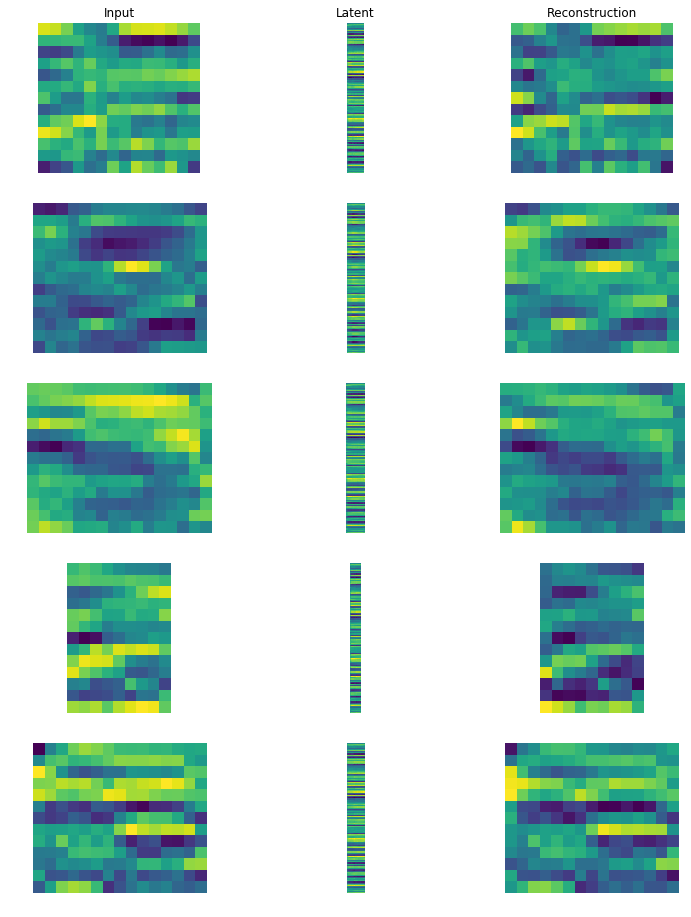

In [23]:
# Plot reconstruction and latent
plot_latent_reconstruction(np_x, np_z, np_y, np_x_lengths, plot_indices=range(5), figsize=(12, 16))

Input shape: (13, 15)
Latent shape: (130, 14)
Reconstruction shape: (13, 14)


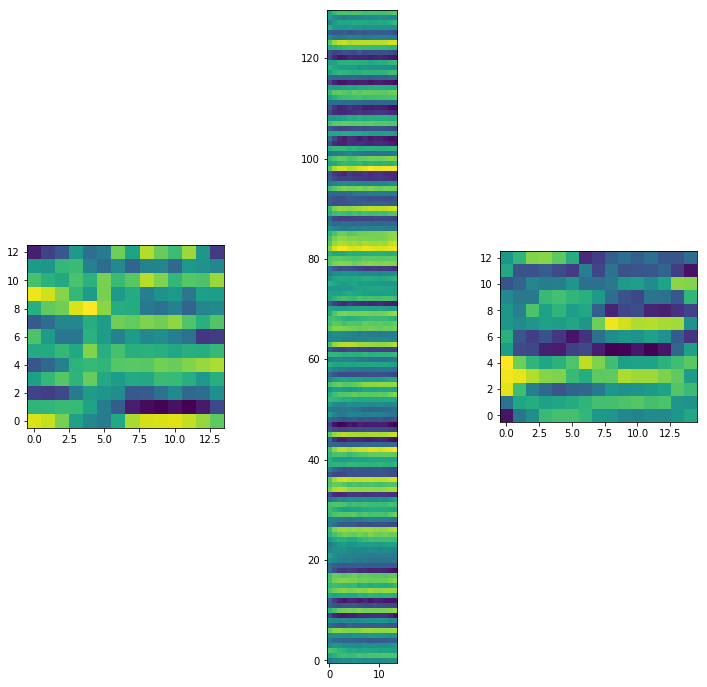

In [24]:
# In more detail (time on horizontal axis, features on vertical)
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(np_x[0][:np_x_lengths[0]].T, origin="bottom")
print("Input shape:", np_x[0][:np_x_lengths[4]].T.shape)

plt.subplot(1, 3, 2)
plt.imshow(np_z[0][:np_x_lengths[0]].T, origin="bottom")
print("Latent shape:", np_z[0][:np_x_lengths[0]].T.shape)

plt.subplot(1, 3, 3)
plt.imshow(np_y[4][:np_x_lengths[4]].T, origin="bottom")
print("Reconstruction shape:", np_y[0][:np_x_lengths[0]].T.shape)

### Train seq2seq with vanilla autoencoder bottleneck (with speaker conditional)

In [25]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
# ----------------
n_speakers = max(speaker_to_id.values()) + 1
dim_speaker_embedding = 100

encoder_hidden_units = [10]
decoder_hidden_units = [10]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_autoencoder
latent_kwargs = {
    "encoder_hidden_units": [],
    "z_units": 130,
    "decoder_hidden_units": [],  # [decoder_hidden_units[0]],
    "activation": "relu"
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"

# Many-to-many autoencoder model
# ------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_recon_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_recon_feats], name="x_recon")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")
speaker_id_tf = tf.placeholder(TF_INT_DTYPE, [None])

with tf.variable_scope("speaker_embedding"):
    speaker_embedding = tf.get_variable("embed",
                                        [n_speakers, dim_speaker_embedding],
                                        dtype=TF_FLOAT_DTYPE)
    embedding_lookup = tf.nn.embedding_lookup(speaker_embedding, speaker_id_tf)

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units, latent_transform, latent_kwargs,
    rnn_cell="lstm", rnn_cell_kwargs=None, keep_prob=1., decoder_conditioning=embedding_lookup,
    dim_output_feats=dim_recon_feats)

encoder_output = network_dict["encoder_output"]
max_length = network_dict["max_length"]
latent_output = network_dict["latent_output"]
z_latent = tf.reshape(latent_output["z"], [-1, max_length, latent_kwargs["z_units"]])
decoder_output = network_dict["decoder_output"]
mask = network_dict["mask"]

decoder_output *= tf.expand_dims(mask, -1)  # doubly make sure that output is zero where input was padded

# Reconstruction loss
# https://danijar.com/variable-sequence-lengths-in-tensorflow/
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x_recon_tf - decoder_output), -1), -1) / tf.reduce_sum(mask, 1))

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model storage
# -------------
intermediate_model_file = os.path.join(output_dir, "many_to_many_ae_speaker_cond.tmp.ckpt")
model_file = os.path.join(output_dir, "many_to_many_ae_speaker_cond.ckpt")

In [26]:
vis.show_tf_graph(tf.get_default_graph())

In [27]:
np.random.seed(1)
train_batch_iterator = batching.BucketRNNBatcher(x_input=input_train["x"],
                                                 x_recon=recon_train["x"],
                                                 batch_size=batch_size,
                                                 speaker_ids=train_speaker_id,
                                                 n_buckets=n_buckets,
                                                 shuffle_every_epoch=True)
test_batch_iterator = batching.BucketRNNBatcher(x_input=input_test["x"],
                                                x_recon=recon_test["x"],
                                                speaker_ids=test_speaker_id,
                                                batch_size=batch_size,
                                                n_buckets=n_buckets,
                                                shuffle_every_epoch=False)

In [28]:
record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x_input_tf, x_recon_tf, speaker_id_tf, x_lengths_tf],
    loss, test_batch_iterator, save_best_val_model_fn=model_file)

2019-02-06 12:49:51.409039
Epoch 0:
38.658 sec, train loss: 0.78047514, val loss: 0.517896 *
Epoch 1:
38.320 sec, train loss: 0.39011958, val loss: 0.31070855 *
Epoch 2:
38.182 sec, train loss: 0.24427058, val loss: 0.24234007 *
Epoch 3:
38.075 sec, train loss: 0.19089945, val loss: 0.20986934 *
Epoch 4:
38.059 sec, train loss: 0.16133517, val loss: 0.19040611 *
Epoch 5:
38.217 sec, train loss: 0.14281209, val loss: 0.17457628 *
Epoch 6:
38.175 sec, train loss: 0.13053624, val loss: 0.16343245 *
Epoch 7:
38.010 sec, train loss: 0.12304446, val loss: 0.1562214 *
Epoch 8:
38.105 sec, train loss: 0.1185644, val loss: 0.1509402 *
Epoch 9:
38.106 sec, train loss: 0.11569516, val loss: 0.14691818 *
Epoch 10:
38.099 sec, train loss: 0.113724194, val loss: 0.14336328 *
Epoch 11:
38.484 sec, train loss: 0.112238914, val loss: 0.13990594 *
Epoch 12:
38.155 sec, train loss: 0.111111216, val loss: 0.13692732 *
Epoch 13:
38.105 sec, train loss: 0.11019493, val loss: 0.13425839 *
Epoch 14:
38.038 se

In [29]:
# Embed test data
target_speaker_id = 3  # random choice for now
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_file)
    for batch_x_padded, _, _, batch_x_lengths in test_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z_latent], feed_dict={x_input_tf: np_x, x_lengths_tf: np_x_lengths}
            )[0]
        np_y = session.run(
            [decoder_output], feed_dict={x_input_tf: np_x, x_lengths_tf: np_x_lengths,
                                         speaker_id_tf: np.array([target_speaker_id]*np_x.shape[0])}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from tmp/many_to_many_ae_speaker_cond.ckpt


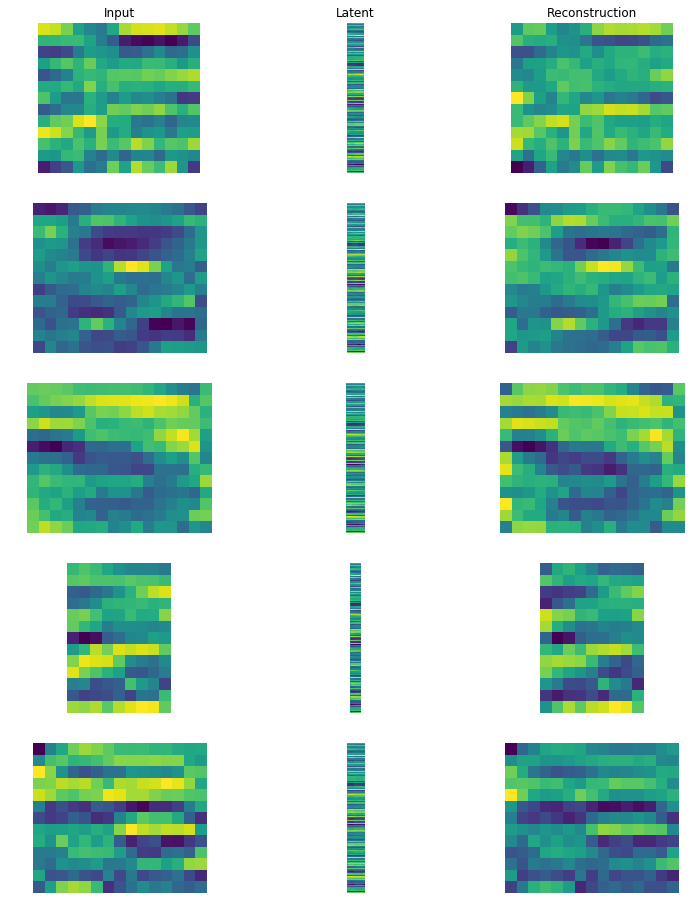

In [30]:
# Plot reconstruction and latent
plot_latent_reconstruction(np_x, np_z, np_y, np_x_lengths, plot_indices=range(5), figsize=(12, 16))

Input shape: (13, 15)
Latent shape: (130, 14)
Reconstruction shape: (13, 14)


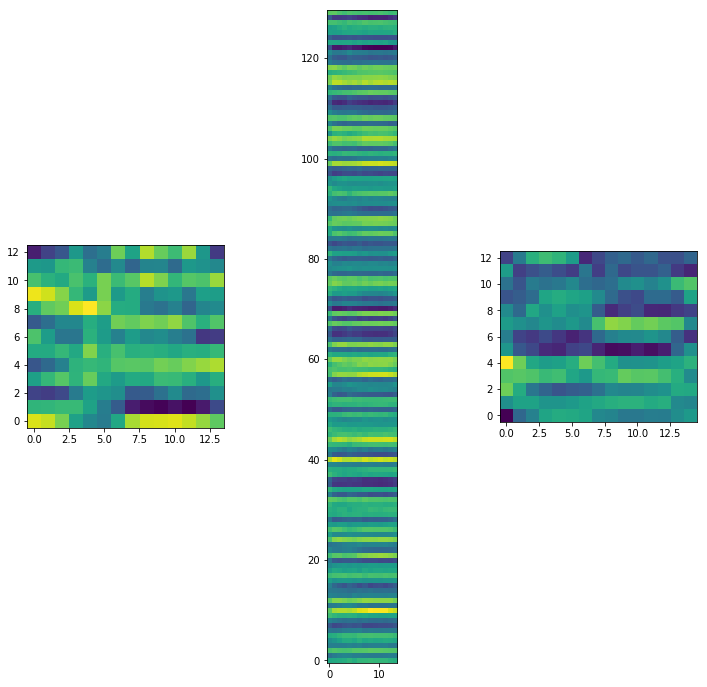

In [31]:
# In more detail (time on horizontal axis, features on vertical)
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(np_x[0][:np_x_lengths[0]].T, origin="bottom")
print("Input shape:", np_x[0][:np_x_lengths[4]].T.shape)

plt.subplot(1, 3, 2)
plt.imshow(np_z[0][:np_x_lengths[0]].T, origin="bottom")
print("Latent shape:", np_z[0][:np_x_lengths[0]].T.shape)

plt.subplot(1, 3, 3)
plt.imshow(np_y[4][:np_x_lengths[4]].T, origin="bottom")
print("Reconstruction shape:", np_y[0][:np_x_lengths[0]].T.shape)

### Train seq2seq with VAE bottleneck (without speaker conditional)

In [32]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
# ----------------
encoder_hidden_units = []
decoder_hidden_units = [100]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_vae
latent_kwargs = {
    "encoder_hidden_units": [],
    "z_units": 130,
    "decoder_hidden_units": [],  # [decoder_hidden_units[0]],
    "activation": "relu"
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"

# Many-to-many seq2seq VAE bottlneck model
# ----------------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_input_feats], name="x_input")
x_recon_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_recon_feats], name="x_recon")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units, latent_transform, latent_kwargs,
    rnn_cell="lstm", rnn_cell_kwargs=None, keep_prob=1., decoder_conditioning=None,
    dim_output_feats=dim_recon_feats)

encoder_output = network_dict["encoder_output"]
max_length = network_dict["max_length"]
latent_output = network_dict["latent_output"]
z_mean = latent_output["z_mean"], 
z_log_sigma_sq = latent_output["z_log_sigma_sq"]
z_latent = tf.reshape(latent_output["z"], [-1, max_length, latent_kwargs["z_units"]])  # reshape to frame-level
decoder_output = network_dict["decoder_output"]
mask = network_dict["mask"]

decoder_output *= tf.expand_dims(mask, -1)  # doubly make sure that output is zero where input was padded

# Reconstruction loss
# https://danijar.com/variable-sequence-lengths-in-tensorflow/
# loss = tf.reduce_mean(
#     tf.reduce_sum(tf.reduce_mean(tf.square(x_recon_tf - decoder_output), -1), -1) / tf.reduce_sum(mask, 1))

sigma_sq = 0.001  # smaller values: care more about reconstruction
loss = ae.vae_loss_gaussian(x_recon_tf, decoder_output, sigma_sq, z_mean, z_log_sigma_sq)

# y = tf.nn.sigmoid(decoder_output)  # use with the Bernoulli loss
# loss = vae_loss_bernoulli(x_recon_tf, y, z_mean, z_log_sigma_sq)

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model storage
# -------------
intermediate_model_file = os.path.join(output_dir, "many_to_many_vae.tmp.ckpt")
model_file = os.path.join(output_dir, "many_to_many_vae.ckpt")


In [33]:
vis.show_tf_graph(tf.get_default_graph())

In [34]:
np.random.seed(1)
train_batch_iterator = batching.BucketRNNBatcher(x_input=input_train["x"],
                                                 x_recon=recon_train["x"],
                                                 batch_size=batch_size,
                                                 n_buckets=n_buckets,
                                                 shuffle_every_epoch=True)
test_batch_iterator = batching.BucketRNNBatcher(x_input=input_test["x"],
                                                x_recon=recon_test["x"],
                                                batch_size=batch_size,
                                                n_buckets=n_buckets,
                                                shuffle_every_epoch=False)

In [35]:
record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x_input_tf, x_recon_tf, x_lengths_tf],
    loss, test_batch_iterator, save_best_val_model_fn=model_file)

2019-02-06 13:02:38.145822
Epoch 0:
39.639 sec, train loss: 353.25293, val loss: 285.34128 *
Epoch 1:
39.481 sec, train loss: 322.3561, val loss: 287.32938
Epoch 2:
39.796 sec, train loss: 319.9376, val loss: 305.48016
Epoch 3:
39.427 sec, train loss: 317.11984, val loss: 313.6009
Epoch 4:
39.458 sec, train loss: 316.4601, val loss: 314.24872
Epoch 5:
39.481 sec, train loss: 316.21448, val loss: 314.83145
Epoch 6:
39.340 sec, train loss: 316.10385, val loss: 315.57892
Epoch 7:
39.503 sec, train loss: 315.87552, val loss: 316.8609
Epoch 8:
39.449 sec, train loss: 315.96338, val loss: 317.10083
Epoch 9:


KeyboardInterrupt: 

In [36]:
# Embed test data
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_file)
    for batch_x_padded, _, batch_x_lengths in test_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z_latent], feed_dict={x_input_tf: np_x, x_lengths_tf: np_x_lengths}
            )[0]
        np_y = session.run(
            [decoder_output], feed_dict={x_input_tf: np_x, x_lengths_tf: np_x_lengths})[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from tmp/many_to_many_vae.ckpt


Input shape: (13, 15)
Latent shape: (130, 14)
Reconstruction shape: (13, 14)


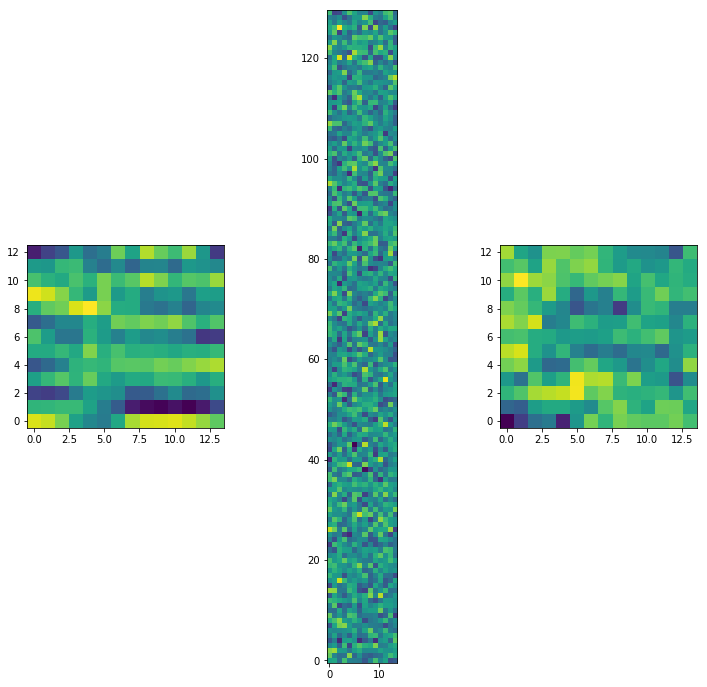

In [37]:
# In more detail (time on horizontal axis, features on vertical)
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(np_x[0][:np_x_lengths[0]].T, origin="bottom")
print("Input shape:", np_x[0][:np_x_lengths[4]].T.shape)

plt.subplot(1, 3, 2)
plt.imshow(np_z[0][:np_x_lengths[0]].T, origin="bottom")
print("Latent shape:", np_z[0][:np_x_lengths[0]].T.shape)

plt.subplot(1, 3, 3)
plt.imshow(np_y[0][:np_x_lengths[0]].T, origin="bottom")
print("Reconstruction shape:", np_y[0][:np_x_lengths[0]].T.shape)